# Beginner's Guide to Machine Learning using Titanic Data Set

![](https://api.time.com/wp-content/uploads/2015/10/titanic-cracker.jpg)


# This notebook is not aimed for a very high score but rather to explain the simplicity of things and methods used. 

# Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Reading the 3 files from the Titanic Data Set

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test  = pd.read_csv('../input/test.csv')
df_sample= pd.read_csv('../input/gender_submission.csv')

# A simple Outlier detection function to find them

In [3]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# Applying the outliers to Age, SibSp, Parch, and Fare columns

In [4]:
Outliers_to_drop = detect_outliers(df_train,2,["Age","SibSp","Parch","Fare"])
df_train = df_train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


# Gotta work a little bit in the Name column, 
# Creating a Title column based on the titles found in Name column, mapping them into numbers and finally removing the Name column

In [5]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in df_train["Name"]]
df_train["Title"] = pd.Series(dataset_title)
df_train["Title"] = df_train["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_train["Title"] = df_train["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df_train["Title"] = df_train["Title"].astype(int)
df_train.drop(labels = ["Name"], axis = 1, inplace = True)

# we need to impute age column, basically fill in the blanks, I'm filling the blanks based on their Priority Class means

In [6]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

# doing the same thing to the fare column

In [7]:
def impute_fare(cols):
    Fare = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Fare):

        if Pclass == 1:
            return 84

        elif Pclass == 2:
            return 20

        else:
            return 13

    else:
        return Fare

# applying these functions to both columns

In [8]:
df_train['Age'] = df_train[['Age','Pclass']].apply(impute_age,axis=1)

# now the gender column, getting rid of the categorical strings and making new dummy columns

In [9]:
sex = pd.get_dummies(df_train['Sex'],drop_first=True)
embark = pd.get_dummies(df_train['Embarked'],drop_first=True)
df_train = pd.concat([df_train,sex,embark],axis=1)

# Making several new features based on the size of the family

In [10]:
df_train["Family"] = df_train["SibSp"] + df_train["Parch"] + 1
df_train['Single'] = df_train['Family'].map(lambda s: 1 if s == 1 else 0)
df_train['SmallF'] = df_train['Family'].map(lambda s: 1 if  s == 2  else 0)
df_train['MedF']   = df_train['Family'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df_train['LargeF'] = df_train['Family'].map(lambda s: 1 if s >= 5 else 0)
df_train['Senior'] = df_train['Age'].map(lambda s:1 if s>60 else 0)

# Appying the previous stuff to the test as well

In [11]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in df_test["Name"]]
df_test["Title"] = pd.Series(dataset_title)
df_test["Title"] = df_test["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_test["Title"] = df_test["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df_test["Title"] = df_test["Title"].astype(int)
df_test.drop(labels = ["Name"], axis = 1, inplace = True)

In [12]:
df_test['Age'] = df_test[['Age','Pclass']].apply(impute_age,axis=1)
sex = pd.get_dummies(df_test['Sex'],drop_first=True)
embark = pd.get_dummies(df_test['Embarked'],drop_first=True)
df_test = pd.concat([df_test,sex,embark],axis=1)

df_test['Fare'].fillna(value=df_test['Fare'].median(),inplace=True)

In [13]:
df_test['Fare'] = df_test[['Fare','Pclass']].apply(impute_fare,axis=1)

In [14]:
df_test["Fare"] = df_test["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

In [15]:
df_test["Family"] = df_test["SibSp"] + df_test["Parch"] + 1

In [16]:
df_test['Single'] = df_test['Family'].map(lambda s: 1 if s == 1 else 0)
df_test['SmallF'] = df_test['Family'].map(lambda s: 1 if  s == 2  else 0)
df_test['MedF']   = df_test['Family'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df_test['LargeF'] = df_test['Family'].map(lambda s: 1 if s >= 5 else 0)
df_test['Senior'] = df_test['Age'].map(lambda s:1 if s>60 else 0)

In [17]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

In [18]:
df_train['Person'] = df_train[['Age','Sex']].apply(get_person,axis=1)
df_test['Person']  = df_test[['Age','Sex']].apply(get_person,axis=1)

person_dummies_train  = pd.get_dummies(df_train['Person'])
person_dummies_train.columns = ['Child','Female','Male']
person_dummies_train.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(df_test['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

df_train = df_train.join(person_dummies_train)
df_test  = df_test.join(person_dummies_test)

df_train.drop(['Person'],axis=1,inplace=True)
df_test.drop(['Person'],axis=1,inplace=True)

In [19]:
df_train.drop('male',axis=1,inplace=True)
df_test.drop('male',axis=1,inplace=True)

In [20]:
df_train.drop(['Cabin','Ticket'],axis = 1, inplace= True)
df_test.drop(['Ticket','Cabin'],axis = 1, inplace= True)

In [21]:
df_train.drop(['Sex','Embarked'],axis=1,inplace=True)
df_test.drop(['Sex','Embarked'],axis=1,inplace=True)

In [22]:
df_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Title,Q,S,Family,Single,SmallF,MedF,LargeF,Senior,Child,Female
0,1,0,3,22.0,1,0,7.2500,2,0,1,2,0,1,0,0,0,0,0
1,2,1,1,38.0,1,0,71.2833,1,0,0,2,0,1,0,0,0,0,1
2,3,1,3,26.0,0,0,7.9250,1,0,1,1,1,0,0,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,1,2,0,1,0,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,2,0,1,1,1,0,0,0,0,0,0


In [23]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Title,Q,S,Family,Single,SmallF,MedF,LargeF,Senior,Child,Female
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.130726,0.455165,0.363224,31.121566,1.590238,0.087401,0.719637,1.818388,0.609535,0.182747,0.148695,0.059024,0.024972,0.094211,0.301930
std,256.617021,0.487090,0.835055,13.304756,0.871571,0.791839,47.996249,0.618903,0.282582,0.449432,1.382086,0.488132,0.386678,0.355989,0.235803,0.156127,0.292288,0.459356
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,448.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,668.000000,1.000000,3.000000,37.000000,1.000000,0.000000,30.500000,2.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200,3.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
df_train.info()
print('.............................................')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 18 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Age            881 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Fare           881 non-null float64
Title          881 non-null int64
Q              881 non-null uint8
S              881 non-null uint8
Family         881 non-null int64
Single         881 non-null int64
SmallF         881 non-null int64
MedF           881 non-null int64
LargeF         881 non-null int64
Senior         881 non-null int64
Child          881 non-null uint8
Female         881 non-null uint8
dtypes: float64(2), int64(12), uint8(4)
memory usage: 99.9 KB
.............................................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int6

# Train Test Split

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train.drop('Survived',axis=1), 
                                                    df_train['Survived'], test_size=0.15, 
                                                    random_state=101)

# Decision Tree (only to show actual trees)

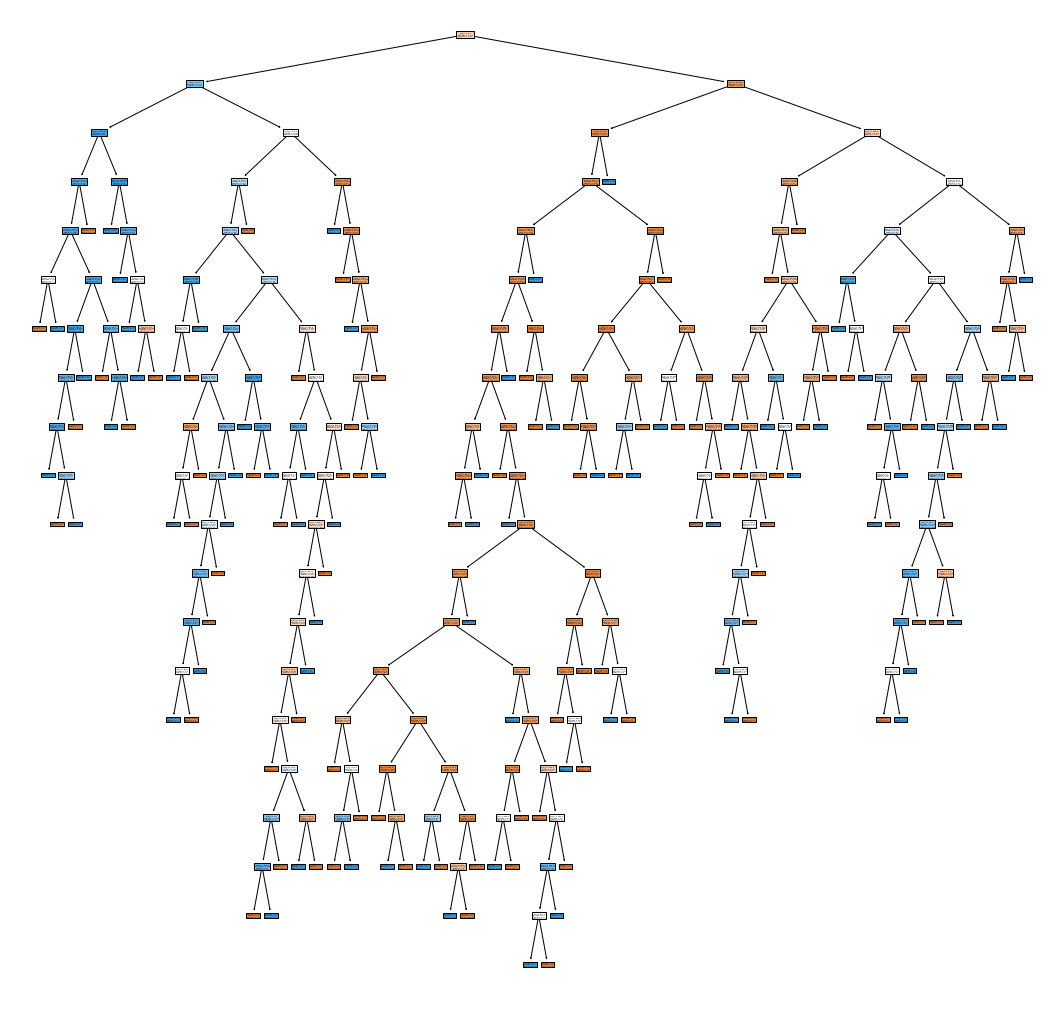

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train);

plt.figure(figsize=(18,18))
plot_tree(dt,filled=True);

# XGBOOST

In [27]:
from xgboost import XGBClassifier

XGB = XGBClassifier(max_depth=4,learning_rate=0.005,n_estimators=500,n_jobs=-1,min_child_weight=2)
XGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.005, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [28]:
y_pred = pd.DataFrame(XGB.predict(df_test))
y_pred['Survived'] = y_pred[0]
y_pred.drop(0,axis=1,inplace=True)
y_pred['PassengerId'] = df_test['PassengerId']
y_pred_xgb = y_pred

y_pred.to_csv('titanic_pred_xgb.csv',index=False)

# Logistic Regression

In [29]:
from sklearn.preprocessing import StandardScaler

Scaler1 = StandardScaler()
Scaler2 = StandardScaler()
X_train_scaled = Scaler1.fit_transform(X_train)
df_test_scaled  = Scaler2.fit_transform(df_test)

In [30]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(C=10).fit(X_train,y_train)

y_pred = pd.DataFrame(logmodel.predict(df_test))

y_pred['Survived'] = y_pred[0]
y_pred.drop(0,axis=1,inplace=True)
y_pred['PassengerId'] = df_test['PassengerId']
y_pred_lr = y_pred

y_pred.to_csv('titanic_pred_logistic.csv',index=False)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=500,max_depth=9,min_samples_split=3)
RFC.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
y_pred = pd.DataFrame(RFC.predict(df_test))

y_pred['Survived'] = y_pred[0]
y_pred.drop(0,axis=1,inplace=True)
y_pred['PassengerId'] = df_test['PassengerId']
y_pred_rf = y_pred
y_pred.to_csv('titanic_pred_rfc.csv',index=False)

# Light GBM

In [33]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(learning_rate=0.01,max_depth=5,n_estimators=500,num_leaves=3).fit(X_train,y_train)

In [34]:
y_pred = pd.DataFrame(lgb.predict(df_test))

y_pred['Survived'] = y_pred[0]
y_pred.drop(0,axis=1,inplace=True)
y_pred['PassengerId'] = df_test['PassengerId']
y_pred_lgb = y_pred
y_pred.to_csv('titanic_pred_lgb.csv',index=False)

# General Scores

In [35]:
print("XGB train score:             ",round(XGB.score(X_train,y_train),2),     "   XGB test score:           ",round(XGB.score(X_test,y_test),2))
print("Log-Reg. train score:        ",round(logmodel.score(X_train,y_train),2),"   Log-Reg. test score:      ",round(logmodel.score(X_test,y_test),2))
print("Random Forest's train score: ",round(RFC.score(X_train,y_train),2),     "   Random Forest test score: ",round(RFC.score(X_test,y_test),2))
print("LGBM train score:            ",round(lgb.score(X_train,y_train),2),     "   LGB Model test score:     ",round(lgb.score(X_test,y_test),2))

XGB train score:              0.87    XGB test score:            0.82
Log-Reg. train score:         0.82    Log-Reg. test score:       0.83
Random Forest's train score:  0.94    Random Forest test score:  0.83
LGBM train score:             0.83    LGB Model test score:      0.84


# Predictions

In [36]:
y_valid_xgb = XGB.predict(X_test)
y_valid_log = logmodel.predict(X_test)
y_valid_rfc = RFC.predict(X_test)
y_valid_lgb = lgb.predict(X_test)

# ROC

In [37]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_valid_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_valid_log)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_valid_rfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_valid_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# Confusion Matrices for 4 models

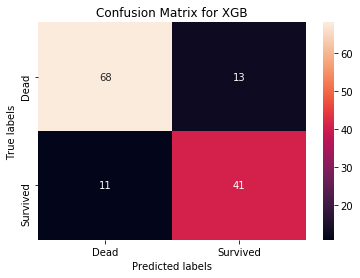

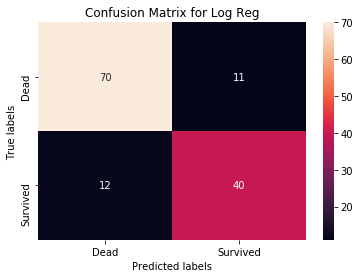

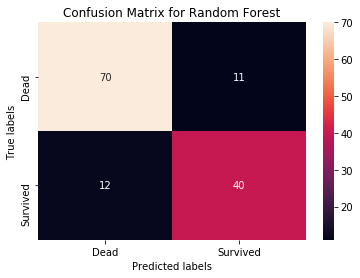

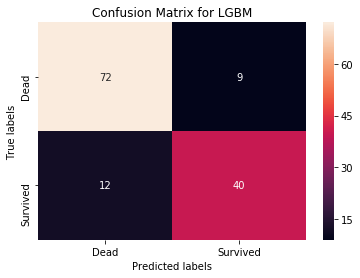

In [38]:
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_valid_xgb), annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for XGB'); 
ax.xaxis.set_ticklabels(['Dead', 'Survived']); ax.yaxis.set_ticklabels(['Dead', 'Survived']);
plt.show()

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_valid_log), annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Log Reg'); 
ax.xaxis.set_ticklabels(['Dead', 'Survived']); ax.yaxis.set_ticklabels(['Dead', 'Survived']);
plt.show()

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_valid_rfc), annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Random Forest'); 
ax.xaxis.set_ticklabels(['Dead', 'Survived']); ax.yaxis.set_ticklabels(['Dead', 'Survived']);
plt.show()

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_valid_lgb), annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for LGBM'); 
ax.xaxis.set_ticklabels(['Dead', 'Survived']); ax.yaxis.set_ticklabels(['Dead', 'Survived']);
plt.show()

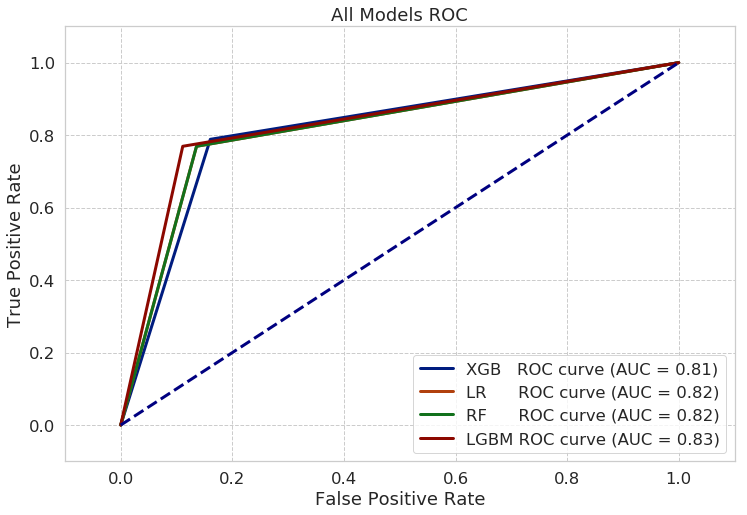

In [39]:
sns.set('talk', 'whitegrid', 'dark', font_scale=1.2,rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
lw = 3
plt.figure(figsize=(12, 8))

sns.despine()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.plot(fpr_xgb, tpr_xgb, lw=lw, label='XGB   ROC curve (AUC = %0.2f)' % roc_auc_xgb);
plt.plot(fpr_log, tpr_log, lw=lw, label='LR      ROC curve (AUC = %0.2f)' % roc_auc_log);
plt.plot(fpr_rfc, tpr_rfc, lw=lw, label='RF      ROC curve (AUC = %0.2f)' % roc_auc_rfc);
plt.plot(fpr_lgb, tpr_lgb, lw=lw, label='LGBM ROC curve (AUC = %0.2f)' % roc_auc_lgb);
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Models ROC')
plt.legend(loc="lower right");


# Blend

In [40]:
y_pred_final = y_pred
y_pred_final['Survived'] = round(  0.25 * y_pred_lgb['Survived'] 
                                 + 0.25 * y_pred_rf['Survived'] 
                                 + 0.25 * y_pred_xgb['Survived'] 
                                 + 0.25 * y_pred_lr['Survived'] )

y_pred_final['PassengerId'] = df_test['PassengerId']
y_pred_final['Survived'] = y_pred_final['Survived'].astype(int)
y_pred_final.to_csv('titanic_pred_final.csv',index=False)

In [41]:
y_pred_final['Survived'].value_counts()

0    271
1    147
Name: Survived, dtype: int64